(16281, 1)
(16281, 124)
loss_train: 0.568871254158
loss_test: 0.560840698861
total: 32561
correct: 24720
accuracy: 0.7591904425539756
total: 16281
correct: 12435
accuracy: 0.7637737239727289


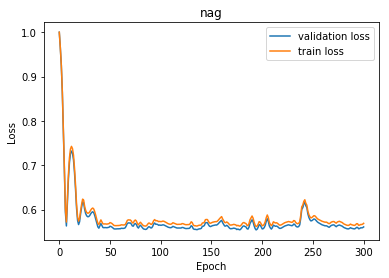

loss_train: 0.563462315123
loss_test: 0.555853504744
total: 32561
correct: 24720
accuracy: 0.7591904425539756
total: 16281
correct: 12435
accuracy: 0.7637737239727289


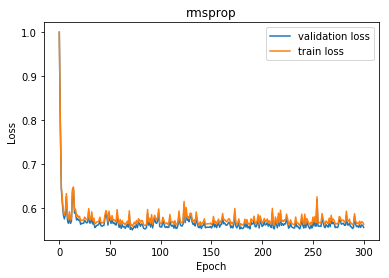

loss_train: 0.557822761282
loss_test: 0.549890385608
total: 32561
correct: 24720
accuracy: 0.7591904425539756
total: 16281
correct: 12435
accuracy: 0.7637737239727289


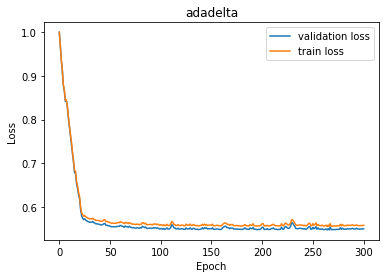

loss_train: 0.569196298993
loss_test: 0.561505082474
total: 32561
correct: 24720
accuracy: 0.7591904425539756
total: 16281
correct: 12435
accuracy: 0.7637737239727289


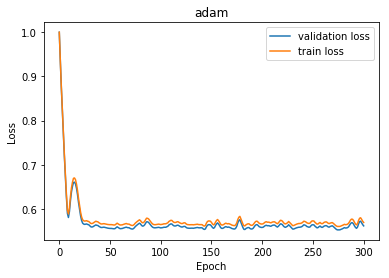

In [4]:
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn import svm

C = 1

#求Loss时分类的判断条件
def hinge_judge(x, y, w):
    return 1 - y * (np.dot(w.T, x)) >= 0

#给定矩阵X，一维向量y,w,b,求Loss（根据公式Loss=0.5*w*w+C*sigma(max(0,1-y[i]*(w^T*x[i]+b)))）
def get_loss(X, y, w):
    loss = 0 #初始化Loss
    #遍历每组数据
    for i in range(X.shape[0]):
        #如果大于0，累加loss
        if(hinge_judge(X[i], y[i], w)):
            loss += 1 - y[i] * (np.dot(w.T, X[i]))
    loss *= C #乘以系数C
    loss /= len(y)
    loss += np.dot(w, w) / 2 #加上求和外的0.5*w*w
    return loss

def get_gradient(X, y, w):
    gradient = np.zeros(shape=[X.shape[1]])
        #遍历每组数据，根据hinge_judge判断该组数据是否对梯度有贡献
    for j in range(len(y)):
        if hinge_judge(X[j], y[j], w):
            gradient -= C * y[j] * X[j]
    
    #对每组数据求和后得到的梯度求均值
    gradient /= len(y)
    
    #w的梯度需要加上w_train
    gradient += w
    
    return gradient

#主要的训练过程，需要传入数据，部分超参数，训练方法和画图列表
def train(X_train, y_train, X_test, y_test, theta, lr, max_epoch, train_way, loss_train, loss_test, epochs):
    #设置SGD的超参数
    batch_size = 16
    gama = 0.95
    beta = 0.9
    epsilon = 1e-6
    #初始化部分SGD方法需要用到的变量
    velocity = np.zeros(shape=[X_train.shape[1]])
    moments = np.zeros(shape=[X_train.shape[1]])
    Gradient = np.zeros(shape=[X_train.shape[1]])
    delta_t = np.zeros(shape=[X_train.shape[1]])
    
    #添加训练之前的画图列表的数据，利用get_loss函数计算此时Loss
    epochs.append(0)
    loss_train.append(get_loss(X_train, y_train, theta))
    loss_test.append(get_loss(X_test, y_test, theta))
    
    for t in range(1, max_epoch + 1):
        #随机取batch_size组数
        batch = np.random.choice(len(y_train), batch_size)
        X_batch, y_batch = X_train[batch], y_train[batch]

        #以下分别是4种SGD算法的实现，一开始均采用get_gradient来
        #求得对应的梯度，然后按各方法进行相应操作
        #（参考https://blog.slinuxer.com/2016/09/sgd-comparison）

        # nag
        if train_way == "nag":
            gradient = get_gradient(X_batch, y_batch, theta - gama * velocity)
            #print("gradient:",gradient.shape,gradient)
            velocity = gama * velocity + lr * gradient
            #print("velocity:",velocity.shape,velocity)
            theta = theta - velocity
        
        # rmsprop
        if train_way == "rmsprop":
            gradient = get_gradient(X_batch, y_batch, theta)
            Gradient = gama * Gradient + (1 - gama) * (gradient * gradient)
            theta = theta - (lr / (np.sqrt(Gradient + epsilon))) * gradient
        
        # adadelta
        if train_way == "adadelta":
            gradient = get_gradient(X_batch, y_batch, theta)
            Gradient = gama * Gradient + (1 - gama) * (gradient * gradient)
            delta_theta = -(np.sqrt(delta_t + epsilon) / np.sqrt(Gradient + epsilon) * gradient)
            theta = theta + delta_theta
            delta_t = gama * delta_t + (1 - gama) * (delta_theta * delta_theta)
        
        # adam
        if train_way == "adam":
            gradient = get_gradient(X_batch, y_batch, theta)
            moments = beta * moments + (1 - beta) * gradient
            Gradient = gama * Gradient + (1 - gama) * (gradient * gradient)
            if t == 0: alpha = 0
            else : alpha = lr * math.sqrt(1 - math.pow(gama, t)) / (1 - math.pow(beta, t))
            theta = theta - alpha * moments / np.sqrt(Gradient + epsilon)
            
        #每次训练结束后，添加画图列表的数据，利用get_loss函数计算此时Loss
        epochs.append(t)
        loss_train.append(get_loss(X_train, y_train, theta))
        loss_test.append(get_loss(X_test, y_test, theta))
    return theta

#输出分类的正确率，分类的阈值为0
def print_correct(X, y, w):
    num_correct = 0 
    for i in range(X.shape[0]):
        if y[i] * (np.dot(w.T, X[i])) >= 0: 
            num_correct += 1
    print("total:", len(y))
    print("correct:", num_correct)
    print("accuracy:", num_correct/len(y))

#读入数据，并将数据转化为array
X_train, y_train = load_svmlight_file("a9a")
X_test, y_test = load_svmlight_file("a9a.t")
X_train = X_train.toarray()
X_test = X_test.toarray()

#训练集增加一列，X=(X:1)
temp = np.ones(shape=[len(y_train),1])
X_train = np.concatenate([X_train,temp], axis=1)

#测试集增加第123个属性（全为零），同时增加一列1
temp = np.zeros(shape=[len(y_test),1])
X_test = np.concatenate([X_test,temp], axis=1)
temp = np.ones(shape=[len(y_test),1])
X_test = np.concatenate([X_test,temp], axis=1)
print(temp.shape)
print(X_test.shape)

#初始化待求参数，使用全零初始化
w_train = np.zeros(shape=[X_train.shape[1]])

#初始化部分超参数（非SGD相关）
max_epoch = 300
lr = 0.01

#定义训练方法的集合
train_way = ["nag", "rmsprop", "adadelta", "adam"]

for i,way in enumerate(train_way):
    #画图列表的初始化，epochs存迭代次数，loss_train为训练集Loss，loss_test为验证集Loss
    epochs = []
    loss_train = []
    loss_test = []
    w_train = np.zeros(shape=[X_train.shape[1]])
    w_train = train(X_train, y_train, X_test, y_test, w_train, lr, max_epoch, way, loss_train, loss_test, epochs)

    #输出最后一次迭代前的训练集和验证集上的Loss，用以调参
    print("loss_train:", loss_train[len(loss_train)-1])
    print("loss_test:", loss_test[len(loss_test)-1])
    
    #调用printCorrect函数，显示训练集和验证集上的正确率
    print_correct(X_train, y_train, w_train)
    print_correct(X_test, y_test, w_train)

    #显示训练集和验证集的Loss随迭代次数增加而变化的图形

    #plt.subplot(2, 2, i + 1)
    plt.plot(epochs, loss_test, label='validation loss')
    plt.plot(epochs, loss_train, label='train loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(way)
    plt.show()

